# Object Localisatie

In dit notebook gaan we twee kernconcepten van computer vision implementeren: object localisatie en object detectie. We zullen deze oefeningen uitvoeren met behulp van zowel PyTorch als Keras, en we gebruiken zowel zelf te trainen netwerken als pre-trained netwerken om de taken te voltooien. Object localisatie is gericht op het vinden van de positie van een enkel object in een afbeelding, terwijl object detectie het vinden van meerdere objecten met hun bijbehorende klassen omvat.

In [17]:
import os
import xml.etree.ElementTree as ET
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import opendatasets as od
import numpy as np

od.download("https://www.kaggle.com/datasets/mbkinaci/image-localization-dataset")

# Helper Functies
def imshow(img, title=None):
    """Toont een afbeelding."""
    npimg = img.numpy() if isinstance(img, torch.Tensor) else img
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.show()

def show_image_with_bbox(image, bbox, title=None):
    """Toont een afbeelding met een bounding box."""
    npimg = image.numpy() if isinstance(image, torch.Tensor) else image
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.gca().add_patch(plt.Rectangle((bbox[0]*128, bbox[1]*128), bbox[2]*128, bbox[3]*128,
                                      fill=False, edgecolor='red', linewidth=2))
    if title:
        plt.title(title)
    plt.show()

Skipping, found downloaded files in "./image-localization-dataset" (use force=True to force download)


## Oefening 1: Object Localisatie met PyTorch

In deze oefening gebruiken we PyTorch om een eenvoudig neuraal netwerk te trainen voor object localisatie. Het doel van object localisatie is om de coördinaten van de bounding box rondom een enkel object in een afbeelding te voorspellen. We maken een convolutioneel neuraal netwerk (CNN) dat leert om vier waarden te voorspellen: de x- en y-coördinaten van de bovenste linkerhoek van de bounding box, en de breedte en hoogte van de box. 

We gebruiken een dummy dataset van willekeurige afbeeldingen en trainen het model om één bounding box te voorspellen voor elke afbeelding.

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128,128))
])

class XMLDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.images = [f for f in os.listdir(self.root_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        # read image
        img_path = os.path.join(self.root_dir, self.images[idx])
        image = Image.open(img_path)

        if self.transform is not None:
            image = self.transform(image)

        # get targets
        xml_path = os.path.splitext(img_path)[0] + '.xml' # vervang .jpg door .xml
        tree = ET.parse(xml_path)
        root = tree.getroot()

        width = float(root.find('size/width').text)
        height = float(root.find('size/height').text)

        bbox = root.find('object/bndbox')
        xmin = float(bbox.find('xmin').text)
        ymin = float(bbox.find('ymin').text)
        xmax = float(bbox.find('xmax').text)
        ymax = float(bbox.find('ymax').text)

        targets = torch.tensor([xmin/width, ymin/height, (xmax-xmin)/width, (ymax-ymin)/height], dtype=torch.float)

        return image, targets

dataset= XMLDataset('./image-localization-dataset/training_images', transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

In [6]:
model = nn.Sequential( #veronderstelling -> 128x128
    # Convolutioneel deel van cnn
    nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
    nn.ReLU(),
    nn.MaxPool2d(2),
    # Flatten gedeelte
    nn.Flatten(),
    # Fully Connected gedeelte
    nn.Linear(16*16*64, 4)  # aantal in = img_size na maxpool2d * img_size na ... * aantal out_channels laatste conv
    # out is 4 voudige regressie (4 getallen voorspellen)
 )

for image, targets in dataloader:
    print(model(image).shape)
    break

torch.Size([8, 4])


In [9]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

num_epochs=10

for epoch in range(num_epochs):
    running_loss = 0.0
    for images, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, targets)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    print(f"Epoch {epoch}/{num_epochs} -> loss: {running_loss/len(dataloader)}")

Epoch 0/10 -> loss: 8.80823733828341
Epoch 1/10 -> loss: 0.039135686897983156
Epoch 2/10 -> loss: 0.024736784708996613
Epoch 3/10 -> loss: 0.024582690365302067
Epoch 4/10 -> loss: 0.02297549570600192
Epoch 5/10 -> loss: 0.02125740540213883
Epoch 6/10 -> loss: 0.020731053159882624
Epoch 7/10 -> loss: 0.021244872904693086
Epoch 8/10 -> loss: 0.017530474811792374
Epoch 9/10 -> loss: 0.01807145382432888


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02577436..1.0000001].


tensor([0.1542, 0.3128, 0.7137, 0.4449])
tensor([0.1808, 0.2699, 0.6567, 0.4028], grad_fn=<SelectBackward0>)


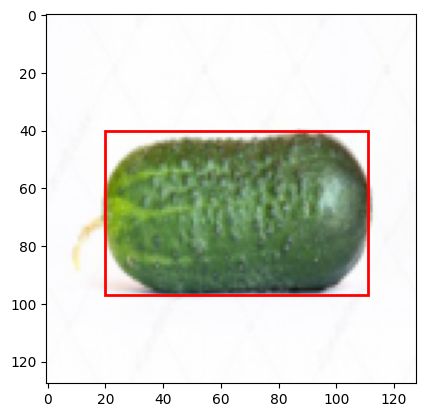

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.02577436..1.0000001].


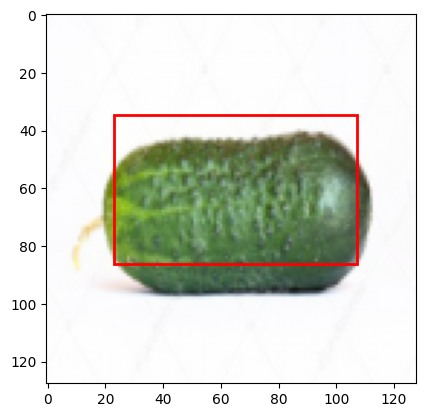

In [19]:
images, targets = next(iter(dataloader)) #(haal de eerste batch op)
outputs = model(images)

print(targets[1])
print(outputs[1])

show_image_with_bbox(images[1], targets[1])
show_image_with_bbox(images[1], outputs[1].detach())

## Oefening 2: Object Detectie met PyTorch

In deze oefening gebruiken we PyTorch om object detectie uit te voeren met een pre-trained Faster R-CNN-model. Faster R-CNN (Region-Based Convolutional Neural Network) is een state-of-the-art model voor object detectie dat zowel de bounding boxes als de klassen van meerdere objecten in een afbeelding kan voorspellen.

We maken gebruik van een pre-trained Faster R-CNN-model dat beschikbaar is via de `torchvision` bibliotheek. Dit model is al getraind op de COCO dataset, dus we kunnen het gebruiken om objecten in nieuwe afbeeldingen te detecteren zonder aanvullende training.

In [ ]:
from torchvision.io.image import decode_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image

img = decode_image("object-detection/img1.jpg")

# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)
model.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()

# Step 3: Apply inference preprocessing transforms
batch = [preprocess(img)]

# Step 4: Use the model and visualize the prediction
prediction = model(batch)[0]
labels = [weights.meta["categories"][i] for i in prediction["labels"]]
box = draw_bounding_boxes(img, boxes=prediction["boxes"],
                          labels=labels,
                          colors="red",
                          width=4, font_size=30)
im = to_pil_image(box.detach())
im.show()

## Oefening 3: Object Localisatie met Keras

In deze oefening implementeren we object localisatie met Keras. Net als in Oefening 1 bouwen we een eenvoudig CNN-model dat leert om de coördinaten van een bounding box te voorspellen voor een enkel object in een afbeelding. Dit model wordt getraind op een dummy dataset met willekeurige afbeeldingen en dummy bounding box-coördinaten.

Het model bestaat uit een reeks convolutie- en poolinglagen, gevolgd door volledig verbonden lagen die de bounding box-coördinaten voorspellen. We gebruiken Mean Squared Error (MSE) als de verliesfunctie om de coördinaten te trainen.